# Coffea Processors
stripped down version from: https://coffeateam.github.io/coffea/notebooks/processor.html

and also Nick Manganelli's example

In [1]:
import awkward as ak
from coffea import processor
from coffea.nanoevents.methods import candidate
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.dataset_tools import apply_to_fileset, max_chunks, max_files, preprocess
from coffea.analysis_tools import PackedSelection

import hist
import dask
from hist.dask import Hist

import matplotlib.pyplot as plt
import numpy as np
import mplhep
mplhep.style.use(mplhep.style.CMS)

class MyProcessor(processor.ProcessorABC):
    def __init__(self):
        self.schema = NanoAODSchema

    def process(self, events):
        dataset = events.metadata['dataset']

        if dataset == "TChiWZ":
            events = events[events.GenModel.TChiWZ_ZToLL_300_295]

        if dataset == "TSlepSlep":
            events = events[events.GenModel.TSlepSlep_300_280]
        
        electrons = events.Electron
        lpte = events.LowPtElectron
        total_entries = ak.num(events, axis=0)
        
        pt_dist = (
            Hist.new
            .Regular(60, 0, 30, name="pt", label="Electron $p_T$ [GeV]") #histogram, 60 bins between 0 and 30
            .Double()
        )
        
        ID_vs_pt = (
            Hist.new
            .Regular(50, 1, 5, name="pt", label="Electron $\eta$")
            .Regular(100, 0, 6, name="ID", label="Electron $p_T$ [GeV]")  
            .Double()
        )
        
        cut = (
            #(lpt_ele.pt <= 5) & 
            (np.abs(lpte.eta) < 2.4) & 
            #(sip3D(dxy, dxyErr, dz, dzErr) < 8) & 
            (np.abs(lpte.dxy) < 0.05) & 
            (np.abs(lpte.dz) < 0.1) & 
            (lpte.miniPFRelIso_all < (20 + 300/lpte.pt))
        )
        
        sel_lpte = lpte[cut]
        
        sel_lpte_genflav1 = sel_lpte[(sel_lpte.genPartFlav == 1) & (sel_lpte.pt <= 5)]

        count_lpte = ak.sum(ak.num(sel_lpte))
        
        pt_dist.fill(pt=ak.flatten(sel_lpte.pt))
        ID_vs_pt.fill(pt=ak.flatten(sel_lpte_genflav1.pt), ID=ak.flatten(sel_lpte_genflav1.ID))
        
        
        output = {
            "entries": total_entries,
            "count_lpte": count_lpte,
            "pt": pt_dist,
            "ID_vs_pt": ID_vs_pt,
        }
            
        return output
    
    def postprocess(self, accumulator):
        pass


/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Wed/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/coffea/nanoevents/schemas/fcc.py:5: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


In [2]:
fileset = {
    'ttbar': {
        "files": {
            '/eos/user/d/dgrove/datasets/ttbar_nAODv9/040206C8-D83C-BA42-BE3F-C3CB0920BEED.root': "Events",
            '/eos/user/d/dgrove/datasets/ttbar_nAODv9/0C483F40-C7FA-0445-B1A0-0C90E2450527.root': "Events",
            '/eos/user/d/dgrove/datasets/ttbar_nAODv9/12D57CAF-00C5-484F-B744-5BA50CDC7540.root': "Events",
            
        },
        "metadata": {
            "is_mc": True,
            "is_signal": False,
        },
    },
    'WZ': {
        "files": {
            '/eos/user/d/dgrove/datasets/WZ_MC/34A260AF-5CF4-5648-BF9F-B84B7A5F2859.root': "Events",
            '/eos/user/d/dgrove/datasets/WZ_MC/E4F05A6C-CBDD-254C-ABBD-38B7A5E81EB3.root': "Events",
        },
        "metadata": {
            "is_mc": True,
            "is_signal": False,
        },
    },
    'TSlepSlep': {
        "files": {
            '/eos/user/d/dgrove/datasets/TSlepSlep/5244169E-4F18-F649-BE1C-C327F93D668C.root': "Events",
            '/eos/user/d/dgrove/datasets/TSlepSlep/6EAFD443-B388-6841-892C-821A020505AA.root': "Events",
            '/eos/user/d/dgrove/datasets/TSlepSlep/78B9FAED-5A2C-7540-89F0-507185DF146D.root': "Events",
            '/eos/user/d/dgrove/datasets/TSlepSlep/CAD43160-4DB5-5445-A0B3-C88CCAC73F61': "Events",
        },
        "metadata": {
            "is_mc": True,
            "is_signal": True,
        },
    },
    'TChiWZ': {
        "files": {
            '/eos/user/d/dgrove/datasets/TChiWZ/0B041116-DADF-CF45-8C16-DF2920CC756D.root': "Events",
            '/eos/user/d/dgrove/datasets/TChiWZ/1D4A080A-4230-7D44-BC89-7569261BDEB7.root': "Events",
            '/eos/user/d/dgrove/datasets/TChiWZ/24CC610C-2F7E-C64D-AF51-48CCDF98DE28.root': "Events",
            '/eos/user/d/dgrove/datasets/TChiWZ/42F85F0D-CD12-414D-A062-EA16FBECBE74.root': "Events",
        },
        "metadata": {
            "is_mc": True,
            "is_signal": True,
        },
    }
}

In [3]:
preprocessed_available, preprocessed_total = preprocess(
        fileset,
        step_size=100_000,
        align_clusters=None,
        skip_bad_files=True,
        recalculate_steps=False,
        files_per_batch=1,
        file_exceptions=(OSError,),
        save_form=True,
        uproot_options={},
        step_size_safety_factor=0.5,
    )

In [4]:
test_preprocessed_files = max_files(preprocessed_available, 1)
test_preprocessed = max_chunks(test_preprocessed_files, 3)

In [5]:
#how about a boolean switch for doing small_computed vs full_computed?

### SWITCH HERE ####

reduced_computation = True

####################

if reduced_computation:
    small_tg, small_rep = apply_to_fileset(data_manipulation=MyProcessor(),
                            fileset=test_preprocessed,
                            schemaclass=NanoAODSchema,
                            uproot_options={"allow_read_errors_with_report": (OSError, KeyError)},
                           )
    computed, rep = dask.compute(small_tg, small_rep)
else:
    full_tg, rep = apply_to_fileset(data_manipulation=MyProcessor(),
                            fileset=preprocessed_available,
                            schemaclass=NanoAODSchema,
                            uproot_options={"allow_read_errors_with_report": (OSError, KeyError)},
                           )
    computed, rep = dask.compute(full_tg, rep)

/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Wed/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_electronIdx => Electron
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Wed/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_photonIdx => Photon
  warnings.warn(


In [6]:
#have to call this a second time to get proper scaling, a known bug
mplhep.style.use(mplhep.style.CMS)

<Figure size 432x288 with 0 Axes>

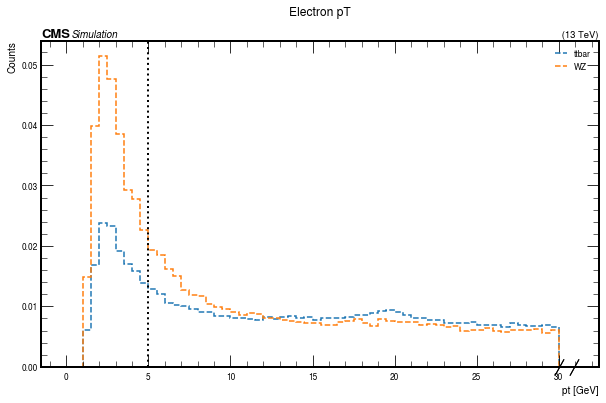

In [7]:
plt.figure()

fig, ax = plt.subplots(figsize=(10, 6))

lpte_ttbar = computed["ttbar"]["count_lpte"]
lpte_WZ = computed["WZ"]["count_lpte"]

norm_ttbar = computed["ttbar"]["pt"]/lpte_ttbar
norm_WZ = computed["WZ"]["pt"]/lpte_WZ

norm_ttbar.plot1d(ax=ax, label="ttbar", linestyle="--")
norm_WZ.plot1d(ax=ax, label="WZ", linestyle="--")

plt.xlabel("pt [GeV]")
plt.ylabel("Counts")
ax.axvline(x=5, color='black', linestyle=':', linewidth=2)
plt.title("Electron pT", pad=25)  # Adjust title position
mplhep.cms.label(loc=0)  # Move CMS label to a different position
plt.legend()
plt.savefig(f"pt_plot_TEST", dpi=120)

Its recommended to create all your code and plotting above using `small_computed` then, once its working and you're satisfied, uncomment lines below then copy paste is below those cells and rerun with `out` to use the full data set

